In [1]:
import sys
sys.path.append('..')

In [2]:
import json
from pprint import pprint
import math
import warnings

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import scipy
import librosa
from scipy import signal

warnings.filterwarnings(
    "ignore", "PySoundFile failed. Trying audioread instead."
)

In [3]:
def plot_xc_spectrogram(xc_id):
    """
    xc_id : xeno-canto id number
    fs    : target sampling rate when loading the file
    """
    x, fs = np.load(f'../data/xeno-canto/numpy/{xc_id}.npy'), 30_000
    
    with open(f'../data/xeno-canto/meta/{xc_id}.json') as f:
        name = json.load(f)['en']
    return plot_spectrogram(x, name, fs)

def plot_spectrogram(x, name, fs):
    # We'll use the hann window because Tensorflow doesnt support tukey
    f, t, Sxx = scipy.signal.spectrogram(x, fs=fs, nperseg=512, window='hann')
    
    fig, axs = plt.subplots(1, 2,
                            figsize=(12, 3),
                            sharey=True,
                            gridspec_kw={'width_ratios': [0.8, 0.2],
                                         'wspace': 0.05})
    
    axs[0].imshow(Sxx ** 0.1,  # exponentiating by 0.1 increases contrast
                  cmap='Greys',
                  origin='lower',
                  extent=[t.min(), t.max(), f.min(), f.max()],
                  aspect='auto')
    
    axs[1].plot(Sxx.mean(axis=1), f)
    
    axs[0].set_title(name)
    axs[0].set_ylabel('Frequency')
    axs[0].set_xlabel('Time (seconds)')
    
    axs[1].set_xlabel('Avg amplitude')
    axs[1].set_xscale('log')
    
    return x

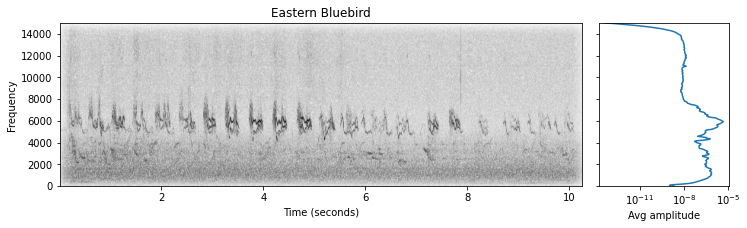

In [4]:
x = plot_xc_spectrogram(100032)
Audio(x, rate=30_000)

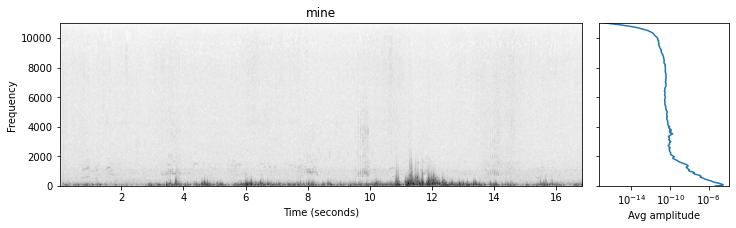

In [5]:
x, fs = librosa.load(Path('../examples/noisy-sandhill-cranes.m4a').expanduser())
sos = signal.butter(10, 1, 'hp', fs=fs, output='sos')
filtered = signal.sosfilt(sos, x)
plot_spectrogram(filtered, 'mine', fs)
Audio(filtered, rate=fs)

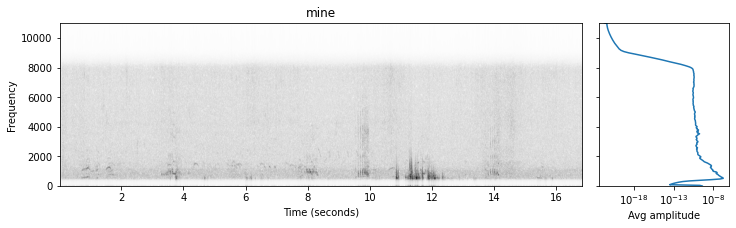

In [6]:
x, fs = librosa.load(Path('../examples/noisy-sandhill-cranes.m4a').expanduser())
sos = signal.butter(20, [500, 8000], 'bandpass', fs=fs, output='sos')
filtered = signal.sosfilt(sos, x)
plot_spectrogram(filtered, 'mine', fs)
Audio(filtered, rate=fs)

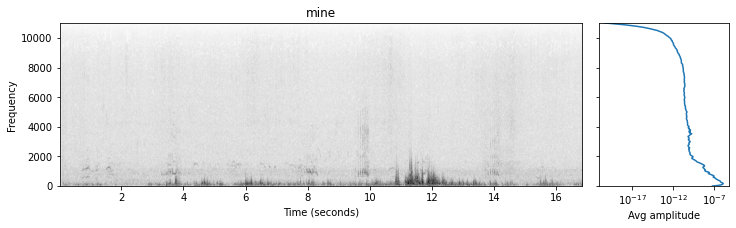

In [7]:
x, fs = librosa.load(Path('../examples/noisy-sandhill-cranes.m4a').expanduser())
b, a = signal.butter(1, [500, 8000], 'bandpass', fs=fs, output='ba')
filtered = signal.lfilter(b, a, x)
plot_spectrogram(filtered, 'mine', fs)
Audio(filtered, rate=fs)

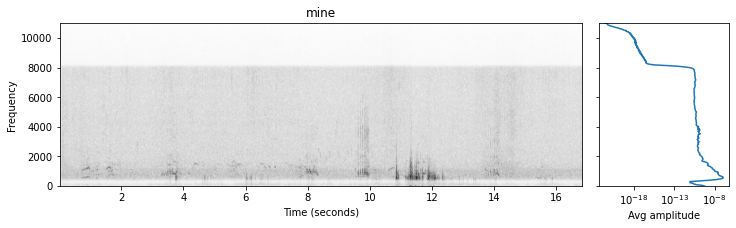

In [8]:
x, fs = librosa.load(Path('../examples/noisy-sandhill-cranes.m4a').expanduser())
b = scipy.signal.firwin(numtaps=255, cutoff=[500, 8000], window='hamming', fs=fs, pass_zero=False)
filtered = signal.lfilter(b, 1, x)
plot_spectrogram(filtered, 'mine', fs)
Audio(filtered, rate=fs)

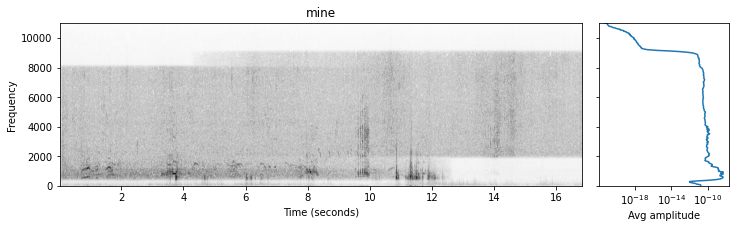

In [9]:
x, fs = librosa.load(Path('../examples/noisy-sandhill-cranes.m4a').expanduser())

b1 = scipy.signal.firwin(numtaps=255, cutoff=[500, 8000], window='hamming', fs=fs, pass_zero=False)
filtered1 = signal.convolve(x, b1)

b2 = scipy.signal.firwin(numtaps=255, cutoff=[2000, 9000], window='hamming', fs=fs, pass_zero=False)
filtered2 = signal.convolve(x, b2)

n = filtered1.size // 4
smoother = np.hstack(([0] * n, (np.linspace(0, 1, n * 2)), [1] * (n + (filtered1.size - (n * 4)))))
y = filtered1 * (1 - smoother) + filtered2 * smoother

plot_spectrogram(y, 'mine', fs)
Audio(y, rate=fs)

In [10]:
def buffer(X, n = 1, p = 0):
    #buffers data vector X into length n column vectors with overlap p
    #excess data at the end of X is discarded
    n = int(n) #length of each data vector
    p = int(p) #overlap of data vectors, 0 <= p < n-1
    L = len(X) #length of data to be buffered
    m = int(np.floor((L-n)/(n-p)) + 1) #number of sample vectors (no padding)
    data = np.zeros([n,m]) #initialize data matrix
    for startIndex,column in zip(range(0,L-n,n-p),range(0,m)):
        data[:,column] = X[startIndex:startIndex + n] #fill in by column
    return data

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       5.59946158e-05, 1.49013062e-04, 0.00000000e+00])

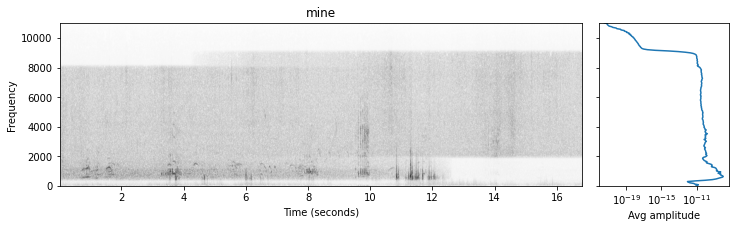

In [11]:
xb = buffer(x, b2.size, b2.size-1).T
n = xb.shape[0]
multer = np.vstack(([b1] * (n // 4), np.linspace(b1, b2, num=n // 4 * 2), [b2] * (n // 4 + (n - n // 4 * 4))))
y2 = (xb * multer).sum(axis=1)
plot_spectrogram(y2, 'mine', fs)

CPU times: user 25.5 s, sys: 559 ms, total: 26.1 s
Wall time: 26.1 s


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       5.59946158e-05, 1.49013062e-04, 0.00000000e+00])

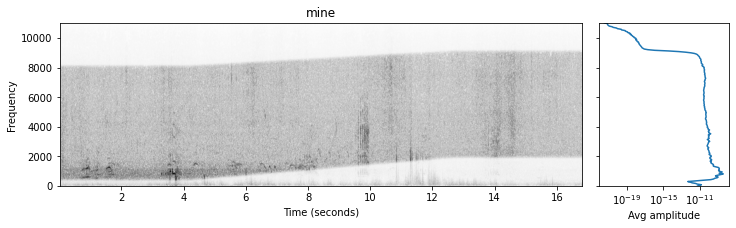

In [12]:
%%time
xb = buffer(x, b2.size, b2.size-1).T
n = xb.shape[0]
def myfirwin(lo, hi):
    return scipy.signal.firwin(numtaps=255, cutoff=[lo, hi], window='hamming', fs=fs, pass_zero=False)
multer = np.vstack(
    (
        [b1] * (n // 4),
        [myfirwin(lo, hi) for lo, hi in np.linspace([500, 8000], [2000, 9000], num=n // 4 * 2)],
        [b2] * (n // 4 + (n - n // 4 * 4))
    )
)
y2 = (xb * multer).sum(axis=1)
plot_spectrogram(y2, 'mine', fs)

In [13]:
def firwin3(n, pass_lo, pass_hi, fs):
    # Adapated from scipy, this is a simplified version of their firwin().
    if not n % 2 or n <= 10:
        raise ValueError("n must be odd and greater than 10")

    # Build hamming window
    fac = np.linspace(-math.pi, math.pi, n)
    hamming_alpha = 0.54  # no idea where this comes from
    win = np.ones(n) * hamming_alpha
    win = win + (1 - hamming_alpha) * np.cos(fac)

    # Build up the coefficients.
    alpha = 0.5 * (n - 1)
    m = np.arange(0, n) - alpha
    left = pass_lo * 2 / fs
    right = pass_hi * 2 / fs
    
    h = right[:, None] * np.sinc(right[:, None] @ m[None, :]) - left[:, None] * np.sinc(left[:, None] @ m[None, :])

    # Modulate coefficients by the window
    coefficients = h * win[None, :]
    return coefficients

In [14]:
%%timeit
firwin3(255, np.linspace(500, 2000, num=100), np.linspace(8000, 9000, num=100), fs)

749 µs ± 1.62 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit
scipy.signal.firwin(numtaps=255, cutoff=[(500 + 2000) / 2, (8000 + 9000) / 2], window='hamming', fs=fs, pass_zero=False)

In [ ]:
%%time
xb = buffer(x, b2.size, b2.size-1).T
n = xb.shape[0]
def myfirwin(lo, hi):
    return scipy.signal.firwin(numtaps=255, cutoff=[lo, hi], window='hamming', fs=fs, pass_zero=False)
multer = np.vstack(
    (
        [b1] * (n // 4),
        firwin3(255, np.linspace(500, 2000, num=n // 4 * 2), np.linspace(8000, 9000, num=n // 4 * 2), fs),
        [b2] * (n // 4 + (n - n // 4 * 4))
    )
)
y2 = (xb * multer).sum(axis=1)
plot_spectrogram(y2, 'mine', fs)